# 210 - First convolution network (CNN) with pytorch

First convolution network on MNIST database.

**Note:** install [tqdm](https://pypi.python.org/pypi/tqdm) if not installed: ``!pip install tqdm``

In [1]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
from pylab import plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
print("torch", torch.__version__)
from torchvision import datasets, transforms
from tqdm import tqdm

torch 0.2.0_4


In [2]:
BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
DATA_DIR = '/home/xd_ensae/data/'
USE_CUDA = True
N_EPOCHS = 50

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [5]:
model = Net()
if USE_CUDA: model = model.cuda()

In [6]:
optimizer = optim.Adam(model.parameters())

In [7]:
def train(epoch, verbose=True):
    model.train()
    losses = []
    loader = tqdm(train_loader, total=len(train_loader))
    for batch_idx, (data, target) in enumerate(loader):
        if USE_CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(float(loss.data[0]))
        if verbose and batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
    return np.mean(losses)

In [8]:
def test(verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if USE_CUDA: data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    if verbose:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return [float(test_loss), correct]

In [9]:
perfs = []
for epoch in range(1, N_EPOCHS + 1):
    t0 = time.time()
    train_loss = train(epoch, verbose=False)
    test_loss, correct = test(verbose=False)
    perfs.append([epoch, train_loss, test_loss, correct, len(test_loader.dataset), time.time() - t0])
    print("epoch {}: train loss {:.4f}, test loss {:.4f}, accuracy {}/{} in {:.2f}s".format(*perfs[-1]))

  1%|          | 11/938 [00:00<00:08, 107.57it/s]

epoch 1: train loss 0.5119, test loss 0.0911, accuracy 9723/10000 in 10.12s


  1%|          | 11/938 [00:00<00:08, 108.18it/s]

epoch 2: train loss 0.2388, test loss 0.0679, accuracy 9778/10000 in 9.75s


  1%|          | 11/938 [00:00<00:09, 101.93it/s]

epoch 3: train loss 0.1990, test loss 0.0565, accuracy 9832/10000 in 9.93s


  1%|          | 11/938 [00:00<00:08, 107.10it/s]

epoch 4: train loss 0.1784, test loss 0.0504, accuracy 9846/10000 in 9.74s


  1%|          | 11/938 [00:00<00:09, 102.07it/s]

epoch 5: train loss 0.1649, test loss 0.0508, accuracy 9834/10000 in 9.79s


  1%|          | 11/938 [00:00<00:08, 104.79it/s]

epoch 6: train loss 0.1533, test loss 0.0463, accuracy 9850/10000 in 9.83s


  1%|          | 11/938 [00:00<00:08, 108.45it/s]

epoch 7: train loss 0.1502, test loss 0.0412, accuracy 9870/10000 in 9.82s


  1%|          | 11/938 [00:00<00:08, 106.89it/s]

epoch 8: train loss 0.1405, test loss 0.0408, accuracy 9875/10000 in 9.63s


  1%|          | 11/938 [00:00<00:08, 108.87it/s]

epoch 9: train loss 0.1363, test loss 0.0384, accuracy 9875/10000 in 9.67s


  1%|          | 11/938 [00:00<00:08, 104.47it/s]

epoch 10: train loss 0.1340, test loss 0.0408, accuracy 9863/10000 in 9.83s


  1%|          | 11/938 [00:00<00:08, 105.57it/s]

epoch 11: train loss 0.1255, test loss 0.0357, accuracy 9883/10000 in 9.80s


  1%|          | 11/938 [00:00<00:08, 108.28it/s]

epoch 12: train loss 0.1247, test loss 0.0373, accuracy 9879/10000 in 9.91s


  1%|          | 11/938 [00:00<00:09, 102.90it/s]

epoch 13: train loss 0.1226, test loss 0.0336, accuracy 9884/10000 in 9.70s


  1%|          | 11/938 [00:00<00:08, 105.48it/s]

epoch 14: train loss 0.1205, test loss 0.0353, accuracy 9882/10000 in 9.78s


  1%|          | 11/938 [00:00<00:09, 101.07it/s]

epoch 15: train loss 0.1194, test loss 0.0372, accuracy 9884/10000 in 9.87s


  1%|          | 11/938 [00:00<00:08, 104.71it/s]

epoch 16: train loss 0.1150, test loss 0.0346, accuracy 9886/10000 in 9.79s


  1%|          | 10/938 [00:00<00:10, 92.67it/s]

epoch 17: train loss 0.1117, test loss 0.0335, accuracy 9894/10000 in 10.16s


  1%|          | 11/938 [00:00<00:08, 108.69it/s]

epoch 18: train loss 0.1097, test loss 0.0321, accuracy 9898/10000 in 10.01s


  1%|          | 11/938 [00:00<00:08, 109.12it/s]

epoch 19: train loss 0.1086, test loss 0.0327, accuracy 9900/10000 in 9.84s


  1%|          | 11/938 [00:00<00:08, 104.64it/s]

epoch 20: train loss 0.1090, test loss 0.0354, accuracy 9895/10000 in 9.89s


  1%|          | 11/938 [00:00<00:08, 107.76it/s]

epoch 21: train loss 0.1066, test loss 0.0319, accuracy 9897/10000 in 10.00s


  1%|          | 11/938 [00:00<00:08, 105.95it/s]

epoch 22: train loss 0.1061, test loss 0.0333, accuracy 9889/10000 in 9.78s


  1%|          | 10/938 [00:00<00:09, 99.41it/s]

epoch 23: train loss 0.1039, test loss 0.0314, accuracy 9907/10000 in 10.13s


  1%|          | 11/938 [00:00<00:08, 106.03it/s]

epoch 24: train loss 0.1019, test loss 0.0313, accuracy 9901/10000 in 9.97s


  1%|          | 11/938 [00:00<00:09, 100.25it/s]

epoch 25: train loss 0.1019, test loss 0.0326, accuracy 9898/10000 in 10.13s


  1%|          | 11/938 [00:00<00:08, 103.92it/s]

epoch 26: train loss 0.0999, test loss 0.0326, accuracy 9901/10000 in 9.84s


  1%|          | 11/938 [00:00<00:08, 108.56it/s]

epoch 27: train loss 0.1014, test loss 0.0326, accuracy 9901/10000 in 9.75s


  1%|          | 11/938 [00:00<00:09, 102.53it/s]

epoch 28: train loss 0.0986, test loss 0.0322, accuracy 9906/10000 in 9.63s


  1%|          | 11/938 [00:00<00:08, 107.72it/s]

epoch 29: train loss 0.1005, test loss 0.0302, accuracy 9897/10000 in 10.10s


  1%|          | 11/938 [00:00<00:08, 103.58it/s]

epoch 30: train loss 0.1001, test loss 0.0309, accuracy 9908/10000 in 9.87s


  1%|          | 11/938 [00:00<00:08, 108.25it/s]

epoch 31: train loss 0.0968, test loss 0.0317, accuracy 9905/10000 in 10.25s


  1%|          | 11/938 [00:00<00:08, 105.79it/s]

epoch 32: train loss 0.0955, test loss 0.0308, accuracy 9905/10000 in 9.86s


  1%|          | 11/938 [00:00<00:08, 106.80it/s]

epoch 33: train loss 0.0947, test loss 0.0291, accuracy 9910/10000 in 10.03s


  1%|          | 11/938 [00:00<00:08, 105.10it/s]

epoch 34: train loss 0.0941, test loss 0.0284, accuracy 9912/10000 in 9.81s


  1%|          | 10/938 [00:00<00:09, 96.53it/s]

epoch 35: train loss 0.0934, test loss 0.0311, accuracy 9913/10000 in 9.81s


  1%|          | 10/938 [00:00<00:09, 96.10it/s]

epoch 36: train loss 0.0952, test loss 0.0295, accuracy 9909/10000 in 9.89s


  1%|          | 10/938 [00:00<00:09, 98.96it/s]

epoch 37: train loss 0.0925, test loss 0.0275, accuracy 9915/10000 in 9.79s


  1%|          | 10/938 [00:00<00:09, 97.61it/s]

epoch 38: train loss 0.0928, test loss 0.0306, accuracy 9903/10000 in 9.78s


  1%|          | 11/938 [00:00<00:08, 104.07it/s]

epoch 39: train loss 0.0907, test loss 0.0305, accuracy 9905/10000 in 9.78s


  1%|          | 11/938 [00:00<00:08, 107.08it/s]

epoch 40: train loss 0.0944, test loss 0.0302, accuracy 9900/10000 in 10.04s


  1%|          | 10/938 [00:00<00:09, 97.66it/s]

epoch 41: train loss 0.0926, test loss 0.0283, accuracy 9915/10000 in 10.14s


  1%|          | 11/938 [00:00<00:08, 106.69it/s]

epoch 42: train loss 0.0903, test loss 0.0313, accuracy 9902/10000 in 9.91s


  1%|          | 11/938 [00:00<00:08, 107.95it/s]

epoch 43: train loss 0.0894, test loss 0.0298, accuracy 9918/10000 in 9.69s


  1%|          | 11/938 [00:00<00:09, 101.87it/s]

epoch 44: train loss 0.0902, test loss 0.0272, accuracy 9921/10000 in 10.06s


  1%|          | 11/938 [00:00<00:08, 106.83it/s]

epoch 45: train loss 0.0918, test loss 0.0274, accuracy 9912/10000 in 9.78s


  1%|          | 11/938 [00:00<00:08, 107.77it/s]

epoch 46: train loss 0.0892, test loss 0.0291, accuracy 9914/10000 in 9.69s


  1%|          | 11/938 [00:00<00:08, 107.35it/s]

epoch 47: train loss 0.0902, test loss 0.0289, accuracy 9912/10000 in 9.80s


  1%|          | 11/938 [00:00<00:08, 106.33it/s]

epoch 48: train loss 0.0891, test loss 0.0286, accuracy 9915/10000 in 10.03s


  1%|          | 11/938 [00:00<00:09, 102.15it/s]

epoch 49: train loss 0.0877, test loss 0.0286, accuracy 9916/10000 in 10.24s


100%|██████████| 938/938 [00:08<00:00, 105.30it/s]


epoch 50: train loss 0.0889, test loss 0.0288, accuracy 9920/10000 in 9.92s


In [10]:
df_perfs = pd.DataFrame(perfs, columns=["epoch", "train_loss", "test_loss", "accuracy", "n_test", "time"])
df_perfs

,epoch,train_loss,test_loss,accuracy,n_test,time
0,1,0.511903,0.091148,9723,10000,10.115877
1,2,0.238817,0.067904,9778,10000,9.749331
2,3,0.199042,0.056497,9832,10000,9.934167
3,4,0.178387,0.050351,9846,10000,9.742947
4,5,0.164874,0.050779,9834,10000,9.793737
5,6,0.153300,0.046292,9850,10000,9.828929
6,7,0.150222,0.041247,9870,10000,9.819250
7,8,0.140527,0.040820,9875,10000,9.634565
8,9,0.136299,0.038373,9875,10000,9.670320
9,10,0.134012,0.040793,9863,10000,9.830047


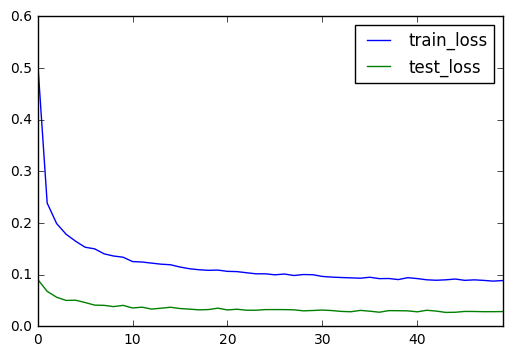

In [11]:
df_perfs[["train_loss", "test_loss"]].plot();

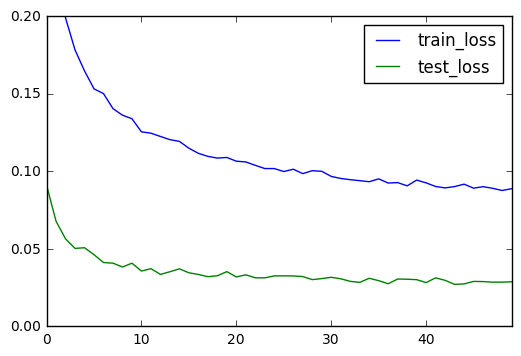

In [12]:
df_perfs[["train_loss", "test_loss"]].plot(ylim=(0, 0.2));